In [ ]:
%load_ext autoreload
%autoreload 2
import os

while not os.path.exists("pyproject.toml"):
    os.chdir("..")
print(f"Changed working directory to {os.getcwd()}")

import scanpy as sc
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Changed working directory to /epyc/projects/dschaub/analysis-projects/spatial-tcr


## Load data

In [ ]:
# TODO: update this path
data_dir = "/epyc/projects/spatialTCR/20240719__094819__human_kidney_7_TCR"
folders = [
    "output-XETG00088__0029040__Region_2__20240719__095641",
    "output-XETG00088__0029040__Region_3__20240719__095641",
    "output-XETG00088__0029040__Region_4__20240719__095642",
    "output-XETG00088__0029040__Region_5__20240719__095642",
    "output-XETG00088__0029040__Region_6__20240719__095642",
    "output-XETG00088__0029040__Region_7__20240719__095642",
    "output-XETG00088__0029041__Region_1__20240719__095642",
    "output-XETG00088__0029041__Region_3__20240719__095642",
    "output-XETG00088__0029041__Region_4__20240719__095642",
    "output-XETG00088__0029041__Region_5__20240719__095642",
    "output-XETG00088__0029041__Region_6__20240719__095642",
    "output-XETG00088__0029041__Region_7__20240719__095642",
    "output-XETG00088__0029041__Region_8__20240719__095642",
]
folder_paths = [os.path.join(data_dir, f) for f in folders]

In [26]:
adatas = []
metadatas = []
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    adata = sc.read_10x_h5(os.path.join(folder_path, "cell_feature_matrix.h5"))
    adata.obs["sample"] = folder.split("-")[-1]
    cells = pd.read_parquet(os.path.join(folder_path, "cells.parquet")).set_index(
        "cell_id"
    )

    adata.obs.index = adata.obs.index + folder
    cells.index = cells.index + folder

    adatas.append(adata)
    metadatas.append(cells)

In [27]:
adata = ad.concat(adatas, uns_merge="unique")
obs = pd.concat(metadatas, axis=0)
obs = obs.loc[adata.obs.index]

adata.obsm["spatial"] = obs.iloc[:, :2].values
adata.obs[obs.columns] = obs
print(adata.obs["cell_area"].isna().sum())

0


In [28]:
adata.obs["slide"] = adata.obs["sample"].str.split("__").str[1]

In [29]:
adata.obs["slide"].value_counts()

slide
0029041    320799
0029040    249112
Name: count, dtype: int64

In [30]:
adata.layers["counts"] = adata.X.copy()

In [31]:
adata.obs["sample"].value_counts()

sample
XETG00088__0029041__Region_1__20240719__095642    89371
XETG00088__0029040__Region_7__20240719__095642    54143
XETG00088__0029040__Region_6__20240719__095642    50960
XETG00088__0029041__Region_4__20240719__095642    50676
XETG00088__0029041__Region_3__20240719__095642    44621
XETG00088__0029041__Region_8__20240719__095642    44598
XETG00088__0029040__Region_2__20240719__095641    43526
XETG00088__0029040__Region_4__20240719__095642    41251
XETG00088__0029041__Region_5__20240719__095642    41112
XETG00088__0029041__Region_7__20240719__095642    34980
XETG00088__0029040__Region_3__20240719__095641    32584
XETG00088__0029040__Region_5__20240719__095642    26648
XETG00088__0029041__Region_6__20240719__095642    15441
Name: count, dtype: int64

## Basic quality control

In [32]:
adata

AnnData object with n_obs × n_vars = 569911 × 480
    obs: 'sample', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'slide'
    obsm: 'spatial'
    layers: 'counts'

In [33]:
adata.obs.cell_area

aaaakcai-1output-XETG00088__0029040__Region_2__20240719__095641    133.617349
aaaeflje-1output-XETG00088__0029040__Region_2__20240719__095641     36.125001
aaagabfi-1output-XETG00088__0029040__Region_2__20240719__095641    117.315942
aaaheakm-1output-XETG00088__0029040__Region_2__20240719__095641     76.675315
aaaikckc-1output-XETG00088__0029040__Region_2__20240719__095641     79.475003
                                                                      ...    
ojlhjkjo-1output-XETG00088__0029041__Region_8__20240719__095642    148.609224
ojlinfan-1output-XETG00088__0029041__Region_8__20240719__095642     54.368127
ojljndaa-1output-XETG00088__0029041__Region_8__20240719__095642    133.256099
ojlnmaeb-1output-XETG00088__0029041__Region_8__20240719__095642     73.469221
ojlolanj-1output-XETG00088__0029041__Region_8__20240719__095642      6.457344
Name: cell_area, Length: 569911, dtype: float64

In [34]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

In [35]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.008202145513835017
Negative decoding count % : 0.005780369863942053


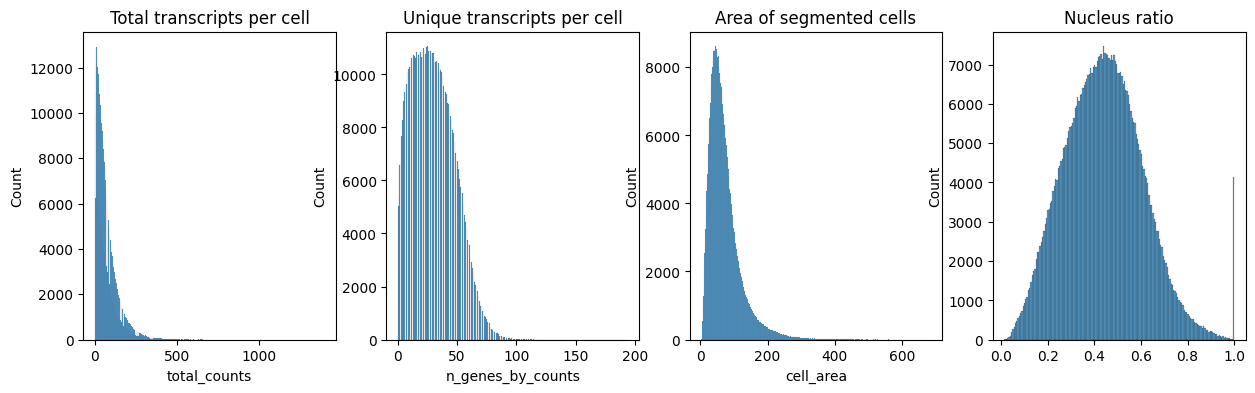

In [36]:
def plot_qc(adata):
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))

    axs[0].set_title("Total transcripts per cell")
    sns.histplot(
        adata.obs["total_counts"],
        kde=False,
        ax=axs[0],
    )

    axs[1].set_title("Unique transcripts per cell")
    sns.histplot(
        adata.obs["n_genes_by_counts"],
        kde=False,
        ax=axs[1],
    )

    axs[2].set_title("Area of segmented cells")
    sns.histplot(
        adata.obs["cell_area"],
        kde=False,
        ax=axs[2],
    )

    axs[3].set_title("Nucleus ratio")
    sns.histplot(
        adata.obs["nucleus_area"] / adata.obs["cell_area"],
        kde=False,
        ax=axs[3],
    )


plot_qc(adata)

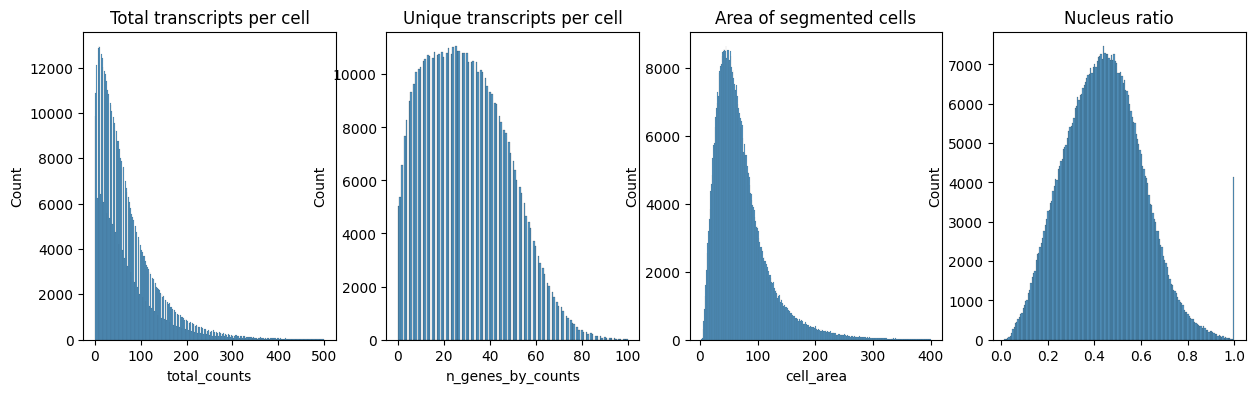

In [37]:
# filter by total transcripts, total unique transcripts, cell area

total_transcripts_limit = 500
unique_transcripts_limit = 100
cell_area_limit = 400

adata = adata[
    (adata.obs["total_counts"] <= total_transcripts_limit)
    & (adata.obs["n_genes_by_counts"] <= unique_transcripts_limit)
    & (adata.obs["cell_area"] <= cell_area_limit)
].copy()
plot_qc(adata)

(510407, 480)

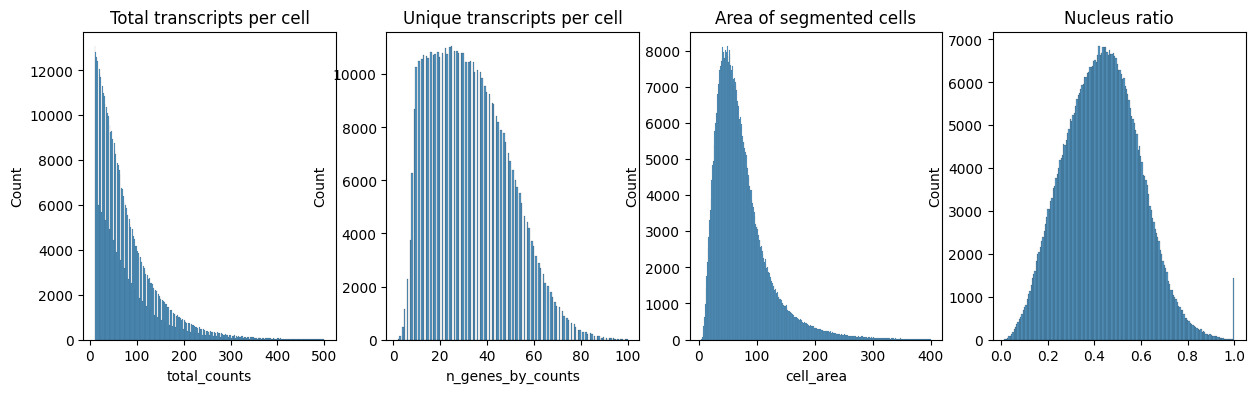

In [38]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)
plot_qc(adata)
adata.shape

## Add metadata

In [39]:
disease_info = {
    "Control": [
        "XETG00088__0029040__Region_2__20240719__095641",
        "XETG00088__0029040__Region_3__20240719__095641",
        "XETG00088__0029041__Region_1__20240719__095642",
    ],
    "ANCA": [
        "XETG00088__0029040__Region_4__20240719__095642",
        "XETG00088__0029040__Region_5__20240719__095642",
        "XETG00088__0029040__Region_6__20240719__095642",
        "XETG00088__0029040__Region_7__20240719__095642",
        "XETG00088__0029041__Region_3__20240719__095642",
        "XETG00088__0029041__Region_4__20240719__095642",
        "XETG00088__0029041__Region_5__20240719__095642",
        "XETG00088__0029041__Region_6__20240719__095642",
        "XETG00088__0029041__Region_7__20240719__095642",
        "XETG00088__0029041__Region_8__20240719__095642",
    ],
    "BK-Virus": ["XETG00088__0029041__Region_2__20240719__095642"],
}

/tmp/ipykernel_1345781/821452480.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(ad_sub, color="CD3D", spot_size=15, cmap="Reds", vmax=1)


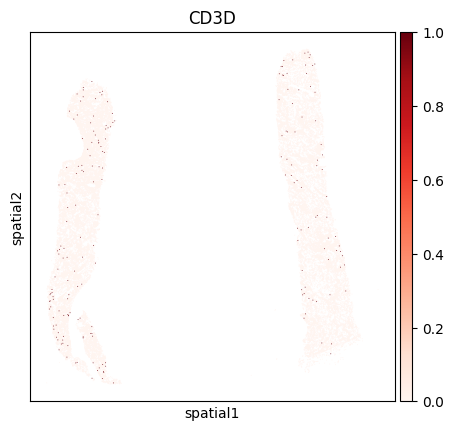

/tmp/ipykernel_1345781/821452480.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(ad_sub, color="CD3D", spot_size=15, cmap="Reds", vmax=1)


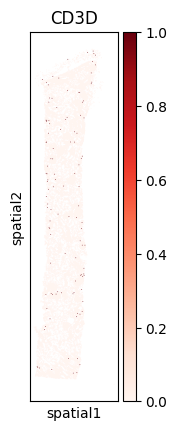

/tmp/ipykernel_1345781/821452480.py:3: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(ad_sub, color="CD3D", spot_size=15, cmap="Reds", vmax=1)


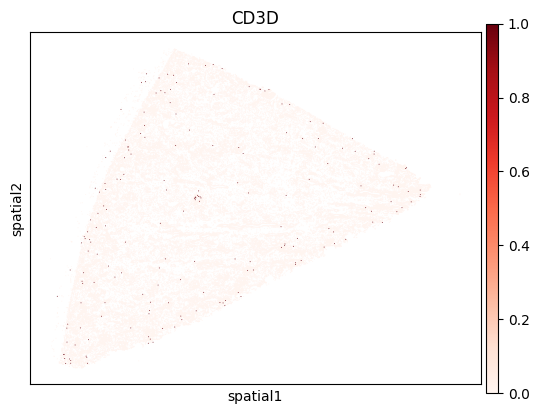

In [40]:
for s in disease_info["Control"]:
    ad_sub = adata[adata.obs["sample"] == s].copy()
    sc.pl.spatial(ad_sub, color="CD3D", spot_size=15, cmap="Reds", vmax=1)

In [41]:
adata.obs["condition"] = adata.obs["sample"]

for condition, samples in disease_info.items():
    mask = adata.obs["sample"].isin(samples)
    adata.obs.loc[mask, "condition"] = condition
adata.obs["condition"].value_counts()

condition
ANCA       389589
Control    120818
Name: count, dtype: int64

## Save anndata

In [42]:
adata.write_h5ad("data/processed/01-kidney_tcr_qc.h5ad")